In [1]:
import pandas as pd
import numpy as np
import pickle
import utils
from collections import Counter
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('challenge_dat.csv')

In [3]:
data.head()

,RESTAURANT_NAME,CITY,COUNTRY,R_PRIMARY_LOC_TAG,R_OTHER_LOC_TAG,R_MENU_CATEGORY,R_OTHER_MENU_TAGS,ITEM_NAME,DESCRIPTION,IS_ALCOHOL
0,Hero Sandwich,Hong Kong,Hong Kong,american,western,Sandwiches,"american, western, burgers, Pasta, Smoothies, ...",Corn Beef Baked Potato,鹹牛肉焗薯,False
1,Hamachi-Ya,Sydney,Australia,japanese,NaN,japanese,"sushi, bento, Cream of the crop, Big flavours,...",Spicy Garlic Edamame,Poached green soy beans tossed with salt fresh...,False
2,Hamachi-Ya,Sydney,Australia,japanese,NaN,japanese,"sushi, bento, Cream of the crop, Big flavours,...",Soft Shell Crab (2pcs),Deep-fried soft shell crab with light ponzu sauce,False
3,Hamachi-Ya,Sydney,Australia,japanese,NaN,japanese,"sushi, bento, Cream of the crop, Big flavours,...",Harumaki (4Pcs),Deep-fried Japanese style vegetable springroll,False
4,Hamachi-Ya,Sydney,Australia,japanese,NaN,japanese,"sushi, bento, Cream of the crop, Big flavours,...",Avocado,NaN,False


In [4]:
ascii_data = data.copy()
#remove non ascii from description, and text items
columns_to_ascii = ['R_OTHER_MENU_TAGS','ITEM_NAME','DESCRIPTION']

In [5]:
ascii_data = ascii_data.dropna(subset=['R_OTHER_MENU_TAGS','DESCRIPTION','ITEM_NAME','R_MENU_CATEGORY','R_PRIMARY_LOC_TAG'])
print(len(ascii_data), ' after na removal')
for col in columns_to_ascii:
    ascii_data[col] = ascii_data[col].astype(str).apply(lambda x: ''.join(['' if ord(i) < 32 or ord(i) > 126 else i for i in x]))
    ascii_data[col].replace('', np.nan, inplace=True)
#remove nan
df = ascii_data.dropna(subset=['R_OTHER_MENU_TAGS','DESCRIPTION','ITEM_NAME','R_MENU_CATEGORY','R_PRIMARY_LOC_TAG'])
print(len(df), ' after ascii')

775109  after na removal
738849  after ascii


In [6]:
#merging the 3 columns
df['food'] = df['R_OTHER_MENU_TAGS'] + "," + df['ITEM_NAME'] + "," + df['DESCRIPTION']
df = df.drop(columns_to_ascii, axis=1)

/Users/aimihat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
df = df[:6000]
tok_df = df.copy()
tok_df['food'] = tok_df['food'].apply(utils.tokenize)

In [8]:
all_words = []
for row in tok_df['food']:
    for word in row.split(','):
        all_words.append(word)

In [23]:
tok_df['food'].to_csv('final.csv')

In [10]:
Counter(all_words).most_common(10)

[('for', 2345),
 ('lunch', 2121),
 ('with', 1728),
 ('onli', 1681),
 ('deliveroo', 1672),
 ('and', 1641),
 ('great', 1417),
 ('chicken', 1121),
 ('pasta', 995),
 ('salad', 989)]

In [11]:
#remove unwanted words
generic_words = ['with', 'and', 'the', 'our', 'your']
for word in generic_words:
    if word in all_words:
        all_words.remove(word)
        
word_set = set(all_words)

In [12]:
encoded_df = tok_df.copy()

In [13]:
#for everyword
for word in word_set:
    #create column with 1 if appears 0 else
    encoded_df[word] = tok_df['food'].str.contains(word)

In [14]:
encoded_df = pd.get_dummies(encoded_df)

In [15]:
encoded_df.head()

,IS_ALCOHOL,food,pecora,asinari,irresist,pop,wing,basilico,impan,powerpass,...,R_MENU_CATEGORY_seafood,R_MENU_CATEGORY_south american,R_MENU_CATEGORY_spanish,R_MENU_CATEGORY_sushi,R_MENU_CATEGORY_thai,R_MENU_CATEGORY_turkish,R_MENU_CATEGORY_vegan,R_MENU_CATEGORY_vegetarian,R_MENU_CATEGORY_venezuelan,R_MENU_CATEGORY_western
1,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
5,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
6,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [16]:
pca = PCA(n_components=2)
pca.fit(encoded_df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [17]:
pca_df = pca.fit_transform(encoded_df)
kmeans = KMeans(n_clusters=6, random_state=0).fit(pca_df)

In [75]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
colors = {0: 'y', 1: u'orchid', 2: u'darkcyan', 3: u'grey', 4: u'dodgerblue', 5: u'turquoise', 6: u'darkviolet'}
for point in pca_df:
    plt.scatter(point[0],point[1],c=colors[kmeans.predict(point.reshape(1, -1))[0]], alpha=0.8)
plt.title('PCA analysis for encoded set of all tokenized words')
#plt.scatter([i[0] for i in kmeans.cluster_centers_], [i[1] for i in kmeans.cluster_centers_], c='k')

/Users/aimihat/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


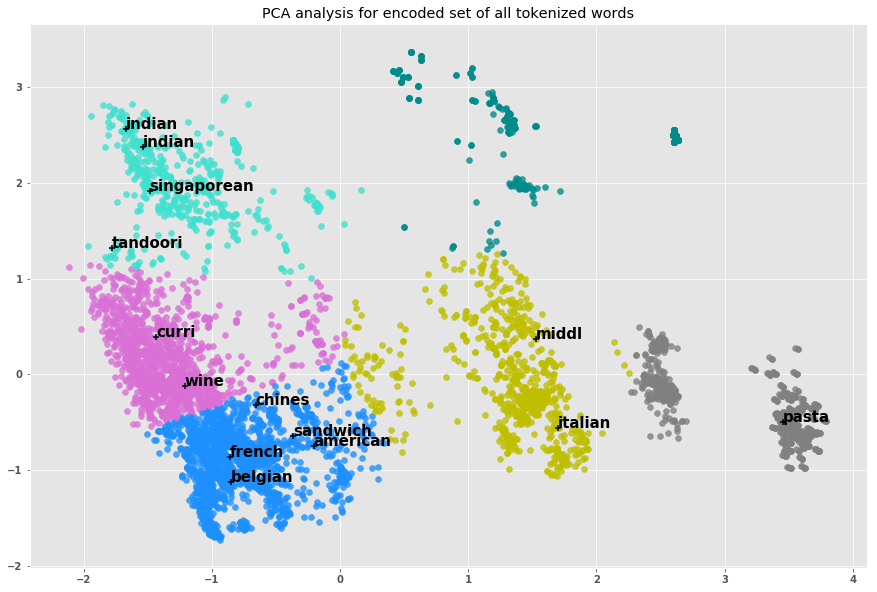

In [76]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)
tok_df['id'] = range(len(tok_df))
for i in [5,6,10, 27, 48, 84,138,1854,2865,1806,1142,1163, 8013,15926]:
    #get word
    word = tok_df['food'].loc[i].split(',')[0]
    plt.scatter(pca_df[tok_df.loc[i].id][0],pca_df[tok_df.loc[i].id][1], c='k', marker="+")
    plt.annotate(word, xy=pca_df[tok_df.loc[i].id][:2])

plt.show()


In [77]:
d = {1:[],2:[],3:[],4:[],5:[],0:[]}
for ind in tok_df.index:
    for word in tok_df.loc[ind]['food'].split(','): 
        d[kmeans.predict(pca_df[tok_df.loc[ind].id].reshape(1, -1))[0]].append(word)

In [71]:
for key in d:
    d[key] = Counter(d[key]).most_common(30)

In [67]:
d.values()

dict_values([[('with', 928), ('curri', 797), ('and', 729), ('chicken', 681), ('tandoori', 479), ('guilti', 345), ('pleasur', 345), ('sauc', 313), ('for', 306), ('the', 304), ('american', 285), ('cream', 261), ('fri', 254), ('beef', 219), ('cook', 215), ('crop', 214), ('perfect', 212), ('onion', 211), ('seafood', 210), ('share', 206)], [('flavour', 306), ('small', 302), ('big', 300), ('price', 300), ('onli', 255), ('deliveroo', 253), ('lunch', 176), ('for', 144), ('local', 135), ('gem', 135), ('great', 122), ('breakfast', 112), ('vietnames', 104), ('chicken', 103), ('free', 101), ('famili', 93), ('favourit', 93), ('with', 89), ('fri', 77), ('dumpl', 75)], [('lunch', 1344), ('for', 925), ('great', 835), ('onli', 834), ('deliveroo', 834), ('pasta', 579), ('love', 511), ('breakfast', 510), ('most', 510), ('met', 228), ('mit', 197), ('sauc', 195), ('und', 144), ('asian', 136), ('fish', 136), ('poulet', 126), ('saumon', 106), ('tomat', 100), ('salad', 96), ('perfect', 95)], [('salad', 588), 